In [96]:
import numpy as np
import glob
def read_alg_list(alg):
    trace_latency_files = glob.glob(alg+'*'+'trace')
    sec_to_lat_list = []
    sec_to_cnt_list = []
    sec_to_miss_list = []
    for f in trace_latency_files:
        print(f)
        with open(f, 'r') as fin:
            lines = fin.readlines()
            sec_to_cnt = []
            sec_to_miss = []
            sec_to_lat = []
            for line in lines:
                tokens = line.split()
                sec = tokens[0]
                sec_to_cnt[sec].append(int(tokens[1]))
                sec_to_miss[sec].append(int(tokens[2]))
                sec_to_lat[sec].append(np.array(tokens[3:], dtype=float32))
            sec_to_lat_list.append(sec_to_lat)
            sec_to_cnt_list.append(sec_to_cnt)
            sec_to_miss_list.append(sec_to_miss)
        if len(sec_to_lat_list) >= 16:
            break
    return sec_to_lat_list, sec_to_cnt_list, sec_to_miss_list

def read_alg(alg):
    trace_latency_files = glob.glob(alg+'*'+'sec')
    sec_to_cnt = []
    sec_to_lat = []
    sec_to_lat_avg = []
    sec_to_miss = []
    i = 0
    for f in trace_latency_files:
        i += 1
        print(f)
        with open(f, 'r') as fin:
            lines = fin.readlines()
            for line in lines:
                tokens = line.split()
                sec = int(tokens[0])
                #if sec > 9000:
                #    break
                if i == 1:
                    sec_to_cnt.append(int(tokens[1]))
                    sec_to_miss.append(int(tokens[2]))
                    sec_to_lat.append(tokens[3:])
                    sec_to_lat_avg.append([np.average(np.array(tokens[3:], dtype=np.int32))])
                else:
                    if len(sec_to_cnt) < sec:
                        print("longer: ", sec)
                        break
                    if sec_to_cnt[sec] != int(tokens[1]):
                        print(sec, int(tokens[1]), sec_to_cnt[sec])
                        break
                    sec_to_miss[sec] += int(tokens[2])
                    sec_to_lat_avg[sec].append(np.average(np.array(tokens[3:], dtype=np.int32)))
                    #print(sec, sec_to_lat[sec])
                    sec_to_lat[sec].extend(tokens[3:])
                    #print(len(tokens[3:]))
                    #print(sec_to_lat[sec], tokens[3:])
        if i >= 16:
            break
    for sec in range(len(sec_to_lat)):
        sec_to_lat[sec] = np.array(sec_to_lat[sec], dtype=np.float32)
        sec_to_miss[sec] /= i
    return sec_to_lat, sec_to_lat_avg, sec_to_cnt, sec_to_miss

In [106]:
names = [ 'LRU', 'EC']#, 'sEC',
alg_sec2lat = {}
alg_sec2lat_avg = {}
alg_sec2cnt = {}
alg_sec2miss = {}

for name in names:
    tup = read_alg('/nfs/512_10_old/'+name)
    alg_sec2lat[name] = tup[0]
    alg_sec2lat_avg[name] = tup[1]
    alg_sec2cnt[name] = tup[2]
    alg_sec2miss[name] = tup[3]
    second_to_n = tup[2]
    print(alg_sec2lat[name][-1])

/nfs/512_10_old/LRU.8.1682886193.sec
/nfs/512_10_old/LRU.11.1682886193.sec
79587 752 2401
/nfs/512_10_old/LRU.15.1682886196.sec
79576 512 2703
/nfs/512_10_old/LRU.6.1682886189.sec
79595 1668 2648
/nfs/512_10_old/LRU.7.1682886191.sec
79601 1612 2762
/nfs/512_10_old/LRU.10.1682886193.sec
79585 1611 2808
/nfs/512_10_old/LRU.9.1682886192.sec
79586 731 2622
/nfs/512_10_old/LRU.3.1682886187.sec
79595 1161 2648
/nfs/512_10_old/LRU.5.1682886187.sec
79596 20 2056
/nfs/512_10_old/LRU.12.1682886194.sec
79595 1087 2648
/nfs/512_10_old/LRU.14.1682886195.sec
79578 928 3011
/nfs/512_10_old/LRU.13.1682886195.sec
79587 830 2401
/nfs/512_10_old/LRU.1.1682886190.sec
79602 3403 2046
/nfs/512_10_old/LRU.0.1682886182.sec
79589 1050 2525
/nfs/512_10_old/LRU.2.1682886183.sec
79579 691 2825
/nfs/512_10_old/LRU.4.1682886185.sec
79577 1321 2841
[8.0000e+01 2.2400e+02 2.1100e+02 1.1500e+02 1.0100e+02 5.4000e+01
 8.2000e+01 2.3600e+02 1.1000e+02 2.2700e+02 5.9000e+01 1.7600e+02
 5.7000e+01 7.6000e+01 2.7700e+02 2.

In [107]:
import math
import itertools
def rolling_sum(n) :
    ret = np.cumsum(second_to_n, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret

def remove_repeat(a, n):
    index = []
    for i in range(len(a)):
        insert = 1
        for k in index:
            if abs(k-a[len(a)-1-i]) < n:
                insert = 0
                break
        if insert:
            index.append(a[len(a)-1-i])
    return np.array(index)

win = 100
rolling_n = rolling_sum(win)
indices = np.argsort(rolling_n)[-300:].astype(int)
print(len(rolling_n))
indices = remove_repeat(indices, win)

print(indices)
print(rolling_n[indices])

alg_lat_peak = {}
alg_miss_peak = {}

for name in names:
    for j in range(len(indices)):
        if j < 10:
            print(name, j, alg_sec2lat_avg[name][indices[j]])
        if j == 0:
            alg_lat_peak[name] = []
            alg_miss_peak[name] = []
        flat = list(itertools.chain.from_iterable(alg_sec2lat[name][indices[j]-win: indices[j]]))
        alg_lat_peak[name].extend(flat)
        alg_miss_peak[name].extend(alg_sec2miss[name][indices[j]-win: indices[j]])
    print(len(alg_lat_peak[name]))
    alg_lat_peak[name] = np.array(alg_lat_peak[name])
    alg_lat_peak[name] = np.sort(alg_lat_peak[name])
print('done')


79594
[58334 58970 52951 58444 58182]
[417580. 407522. 392392. 386013. 379056.]
LRU 0 [1016.6623036649214, 5476.201570680629, 3042.5680628272253, 1196.2591623036649, 1319.5523560209424, 2069.526178010471, 6075.0366492146595, 1416.6125654450261, 950.217277486911, 1915.871727748691, 4538.039267015707, 1159.2277486910996, 1513.8848167539268, 1088.7486910994764, 2999.756544502618, 4750.70942408377]
LRU 1 [804.4774951076321, 4132.424657534247, 2307.587084148728, 928.0724070450098, 1021.5753424657535, 1587.839530332681, 5728.960861056751, 1093.1937377690801, 748.0724070450098, 2980.1369863013697, 3430.12915851272, 1454.4246575342465, 2521.5518590998045, 852.1859099804306, 2278.25831702544, 3586.514677103718]
LRU 2 [1031.337765957447, 5562.154255319149, 3090.0, 1214.026595744681, 1339.1728723404256, 2100.343085106383, 6170.33244680851, 1437.2074468085107, 964.1143617021277, 1941.837765957447, 4609.045212765957, 1175.8218085106382, 1535.9281914893618, 1102.6675531914893, 3046.1170212765956, 48

In [17]:
import matplotlib.pyplot as plt
FONT_SIZE = 24
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=3)
plt.rc('lines', markersize=12)  # size of marker

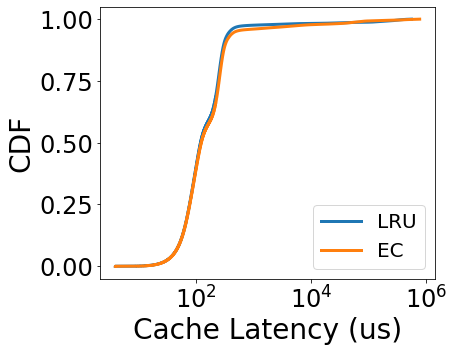

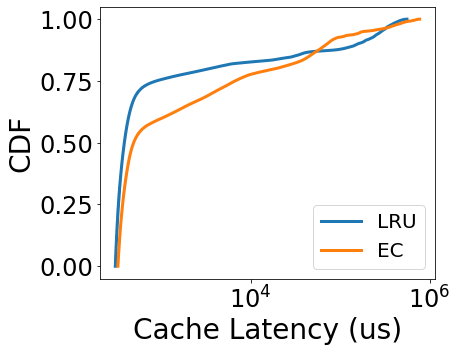

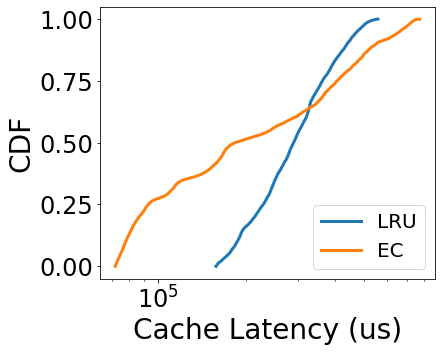

In [99]:
def inverse(x):
    return (x+0.05)**(1/2)


def forward(x):
    return x**2

for n_tail in [0, len(alg_lat_peak['LRU'])//10, len(alg_lat_peak['LRU'])//100]:
    plt.figure(figsize=(6,5))
    for name in names:
        x = alg_lat_peak[name][-n_tail:]
        y = np.arange(len(x))/float(len(x))
        plt.plot(x, y, label=name)

        #plt.yscale('function', functions=(forward, inverse))
    plt.xscale('log')
    plt.xlabel('Cache Latency (us)', fontsize=28)
    plt.ylabel('CDF', fontsize=28)
    plt.legend(ncol=1, prop={'size': 20}, loc='lower right')

    #plt.ylim(top=0.99999)
    #plt.ylim(bottom=bottom)
    plt.show()

'\n11431. 11010. 11002. 10203. 10164. 10107. 10069. 10012.  9835.  9692.\n\n0.097177215\n0.09021858\n0.09085874\n\n63976. 63168. 63027. 62034. 58448\n\n0.20824143\n0.17483594\n0.18511227\n\n417558. 408083. 392546. 386084. 379042.\n\n0.08883875\n0.098440826\n0.091644526\n'

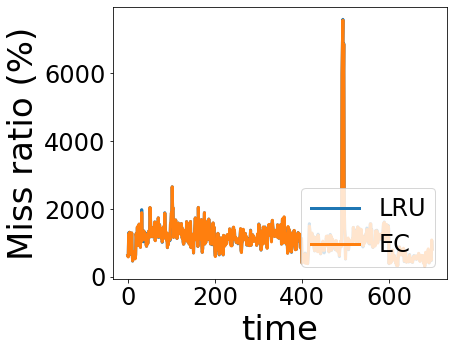

In [100]:
plt.figure(figsize=(6,5))

#a1 = np.average(lru_miss.reshape(-1, n), axis=1)
#a2 = np.average(eci_miss.reshape(-1, n), axis=1)
#a_ec = np.average(ec_miss.reshape(-1, n), axis=1)

for name in names:
    plt.plot(range(len(alg_miss_peak[name])), alg_miss_peak[name], label=name)


plt.xlabel('time', fontsize=34)
plt.ylabel('Miss ratio (%)', fontsize=34)
plt.legend(ncol=1, prop={'size': 24}, loc='lower right')

'''
11431. 11010. 11002. 10203. 10164. 10107. 10069. 10012.  9835.  9692.

0.097177215
0.09021858
0.09085874

63976. 63168. 63027. 62034. 58448

0.20824143
0.17483594
0.18511227

417558. 408083. 392546. 386084. 379042.

0.08883875
0.098440826
0.091644526
'''

(79603,)


AxisError: axis 1 is out of bounds for array of dimension 1

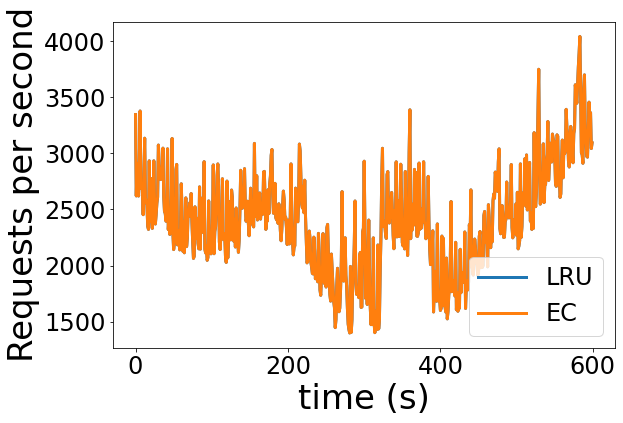

<Figure size 648x432 with 0 Axes>

In [109]:
plt.figure(figsize=(9,6))
n = 100
end = 60000

for name in ['LRU', 'EC']:
    dat = np.average(np.array(alg_sec2cnt[name][:end]).reshape(-1, n), axis=1)
    plt.plot(range(len(dat)), dat, label=name)

plt.xlabel('time (s)', fontsize=34)
plt.ylabel('Requests per second', fontsize=34)
plt.legend(ncol=1, prop={'size': 24}, loc='lower right')


plt.figure(figsize=(9,6))
for name in ['LRU', 'EC']:
    alg_sec2lat[name] = np.array(alg_sec2cnt[name], dtype=np.float32)
    print(alg_sec2lat[name].shape)
    dat = np.average(np.percentile(np.array(alg_sec2lat[name][:end]), 95, axis=1).reshape(-1, n), axis=1)
    plt.plot(range(len(dat)), dat, label=name)

plt.xlabel('time (s)', fontsize=34)
plt.ylabel('Requests per second', fontsize=34)
plt.legend(ncol=1, prop={'size': 24}, loc='lower right')


plt.figure(figsize=(9,6))
for name in ['LRU', 'EC']:
    dat = np.average(np.array(alg_sec2miss[name][:end]).reshape(-1, n), axis=1)
    plt.plot(range(len(dat)), dat, label=name)

plt.xlabel('time (s)', fontsize=34)
plt.ylabel('miss per second', fontsize=34)
plt.legend(ncol=1, prop={'size': 24}, loc='lower right')

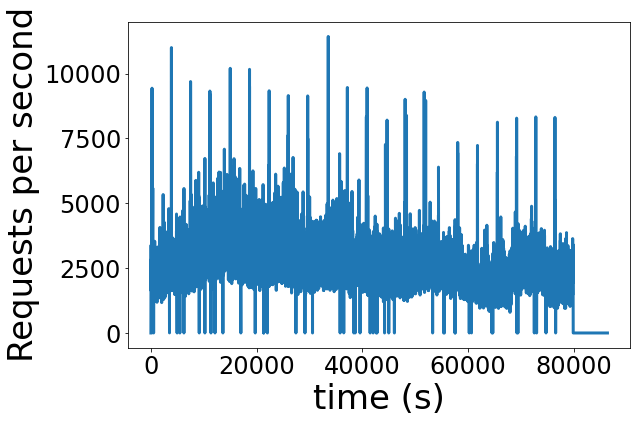

In [125]:
plt.figure(figsize=(9,6))
n = 1
#a_lru = np.average(lru_tt.reshape(-1, n), axis=1)
#a_eci = np.average(eci_tt.reshape(-1, n), axis=1)
m_ine = np.average(second_to_n.reshape(-1, n), axis=1)

plt.plot(np.array(range(len(n_per_seconds))), n_per_seconds, label='1s')

plt.xlabel('time (s)', fontsize=34)
plt.ylabel('Requests per second', fontsize=34)
#plt.legend(ncol=1, prop={'size': 24}, loc='lower right')

indices = np.argsort(n_per_seconds)[-100:].astype(int)
#print(second_to_seq[indices-1])
#print(second_to_seq[indices])
#print(n_per_seconds[indices])

In [66]:
import numpy as np
import glob
def read_latency(alg):
    trace_latency_files = glob.glob(alg+'*'+'trace')
    trace_latency_list = []
    for f in trace_latency_files:
        print(f)
        print(len(trace_latency_list))
        with open(f, 'r') as fin:
            line = fin.readline()
            trace_latency_list.append(np.array(line.split(), dtype=np.float32))
        if len(trace_latency_list) >= 1:
            break
    '''e2e_latency_files = glob.glob(alg+'*'+'e2e')
    for f in e2e_latency_files:
        print(f)
        i = 0
        with open(f, 'r') as fin:
            line = fin.readline()
            if i == 0:
                e2e_latency_list = np.array(line.split(), dtype=np.float32) * 1/len(e2e_latency_files)
            else:
                e2e_latency_list += np.array(line.split(), dtype=np.float32) * 1/len(e2e_latency_files)
            i += 1
    '''
    return trace_latency_list

In [67]:
raw_ine_list = read_latency('/nfs/16_512_new2/EC') #EC-ine
raw_ec_list = read_latency('/nfs/16_512_new2/eEC') #EC
raw_lru_list = read_latency('/nfs/16_512_new2/LRU') #LRU
print(len(raw_lru_list))
#t1 = t1[:len_min]
#t2 = t2[:len_min]

/nfs/16_512_new2/EC.1.1682800054.trace
0
/nfs/16_512_new2/eEC.6.1682800083.trace
0
/nfs/16_512_new2/LRU.13.1682800144.trace
0
1


In [56]:
dname = '/nfs/16_512_new'
names = ['EC_t', 'EC_m', 'eEC_t', 'eEC_m', '1eEC_t', '1eEC_m', 'LRU_t', 'LRU_m']
data = [t_ine, m_ine, t_mat, m_mat, t_1mat, m_1mat, t_lru, m_lru]
for i in range(len(names)):
    with open(f'{dname}/{names[i]}.avg', 'wb') as f:
        np.save(f, data[i])

In [57]:
dname = '/nfs/16_512'
names = ['EC_t', 'EC_e', 'eEC_t', 'eEC_e', 'LRU_t', 'LRU_e']
with open(f'{dname}/EC_t.avg', 'rb') as f:
    t1 = np.load(f)
with open(f'{dname}/EC_e.avg', 'rb') as f:
    e1 = np.load(f)
with open(f'{dname}/eEC_t.avg', 'rb') as f:
    t2 = np.load(f)
with open(f'{dname}/eEC_e.avg', 'rb') as f:
    e2 = np.load(f)
with open(f'{dname}/LRU_t.avg', 'rb') as f:
    t3 = np.load(f)
with open(f'{dname}/LRU_e.avg', 'rb') as f:
    e3 = np.load(f)

In [68]:
n_warmup = 0
CHANNEL_COUNT = 2
t_ine_l = {}
m_ine_l = {}
t_mat_l = {}
m_mat_l = {}
t_1mat_l = {}
m_1mat_l = {}
t_lru_l = {}
m_lru_l = {}
for i in range(len(raw_lru_list)):
    deinterleaved = [raw_ine_list[i][idx::CHANNEL_COUNT] for idx in range(CHANNEL_COUNT)]
    t_ine_l[i] = deinterleaved[0]
    m_ine_l[i] = deinterleaved[1]
    deinterleaved = [raw_ec_list[i][idx::CHANNEL_COUNT] for idx in range(CHANNEL_COUNT)]
    t_mat_l[i] = deinterleaved[0]
    m_mat_l[i] = deinterleaved[1]
    deinterleaved = [raw_1ec_list[i][idx::CHANNEL_COUNT] for idx in range(CHANNEL_COUNT)]
    t_1mat_l[i] = deinterleaved[0]
    m_1mat_l[i] = deinterleaved[1]
    deinterleaved = [raw_lru_list[i][idx::CHANNEL_COUNT] for idx in range(CHANNEL_COUNT)]
    t_lru_l[i] = deinterleaved[0]
    m_lru_l[i] = deinterleaved[1]

    print('avg replay latency (MAT inelastic - LRU) ', np.mean(t_ine_l[i]-t_lru_l[i]), ' us')
    print('avg replay latency (MAT - LRU)           ', np.mean(t_mat_l[i]-t_lru_l[i]), ' us')
    print('avg replay latency (1MAT - LRU)           ', np.mean(t_1mat_l[i]-t_lru_l[i]), ' us')

lat_max = []
for i in range(len(t_ine_l)):
    lat_max.append(t_ine_l[i])
t_ine = np.average(np.array(lat_max), axis=0)
lat_max = []
for i in range(len(t_lru_l)):
    lat_max.append(t_lru_l[i])
t_lru = np.average(np.array(lat_max), axis=0)
lat_max = []
for i in range(len(t_mat_l)):
    lat_max.append(t_mat_l[i])
t_mat = np.average(np.array(lat_max), axis=0)
lat_max = []
for i in range(len(t_1mat_l)):
    lat_max.append(t_1mat_l[i])
t_1mat = np.average(np.array(lat_max), axis=0)

lat_max = []
for i in range(len(m_ine_l)):
    lat_max.append(m_ine_l[i])
m_ine = np.average(np.array(lat_max), axis=0)
lat_max = []
for i in range(len(m_lru_l)):
    lat_max.append(m_lru_l[i])
m_lru = np.average(np.array(lat_max), axis=0)
lat_max = []
for i in range(len(m_mat_l)):
    lat_max.append(m_mat_l[i])
m_mat = np.average(np.array(lat_max), axis=0)
lat_max = []
for i in range(len(m_1mat_l)):
    lat_max.append(m_1mat_l[i])
m_1mat = np.average(np.array(lat_max), axis=0)

avg replay latency (MAT inelastic - LRU)  -3832.0034  us
avg replay latency (MAT - LRU)            -4591.221  us
avg replay latency (1MAT - LRU)            -6844.5127  us


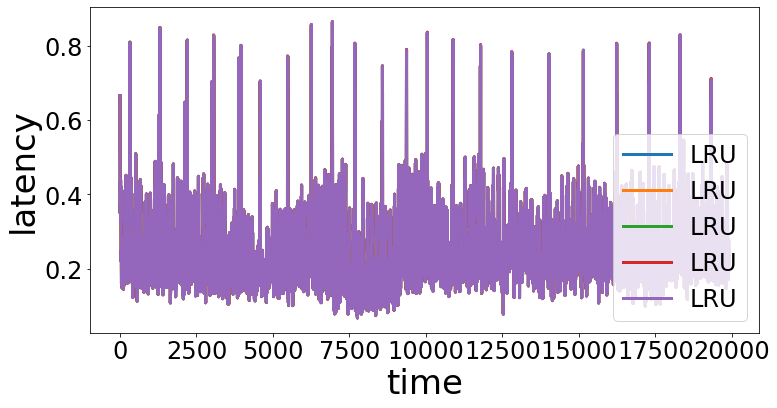

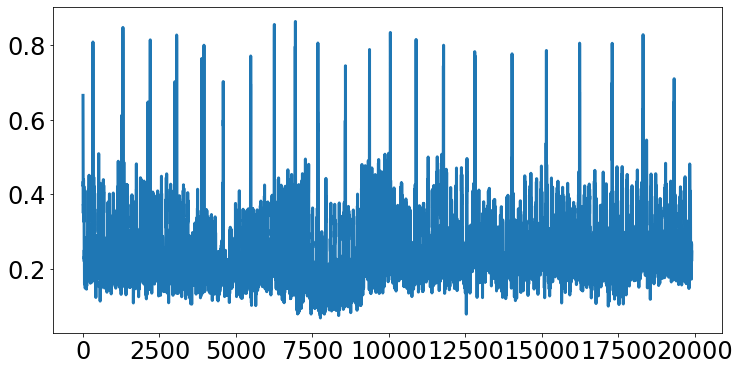

In [35]:
# plot latency vs. time

plt.figure(figsize=(12,6))
n = 10000

metric_list = m_lru

for i in range(len(metric_list)):
    lat = np.average(metric_list[i].reshape(-1, n), axis=1)
    plt.plot(range(len(lat)), lat, label='LRU')


plt.xlabel('time', fontsize=34)
plt.ylabel('latency', fontsize=34)
#plt.yscale('log')
plt.legend(ncol=1, prop={'size': 24}, loc='lower right')
plt.show()

lat_max = []
for i in range(len(metric_list)):
    lat_max.append(np.average(metric_list[i].reshape(-1, n), axis=1))
lat_max = np.average(np.array(lat_max), axis=0)
plt.figure(figsize=(12,6))
plt.plot(range(len(lat_max)), lat_max, label='LRU')

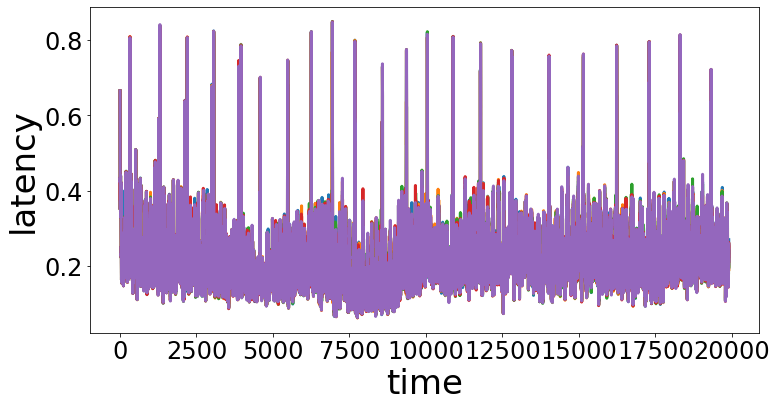

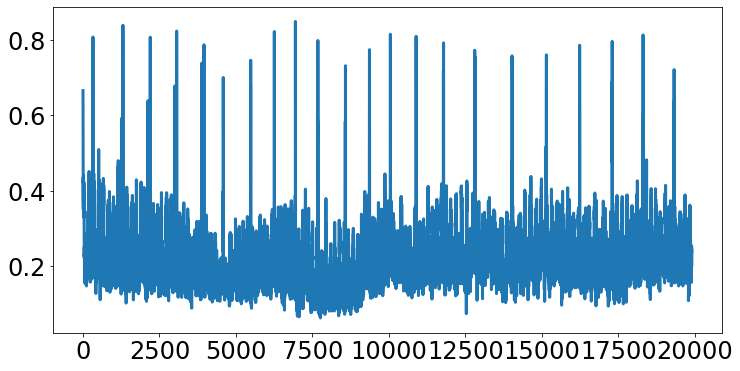

In [34]:
# plot latency vs. time

plt.figure(figsize=(12,6))
n = 10000
metric_list = m_ine

for i in range(len(metric_list)):
    lat = np.average(metric_list[i].reshape(-1, n), axis=1)
    plt.plot(range(len(lat)), lat, label='MAT')


plt.xlabel('time', fontsize=34)
plt.ylabel('latency', fontsize=34)
#plt.yscale('log')
#plt.legend(ncol=1, prop={'size': 24}, loc='lower right')
plt.show()

lat_max = []
for i in range(len(metric_list)):
    lat_max.append(np.average(metric_list[i].reshape(-1, n), axis=1))
lat_max = np.average(np.array(lat_max), axis=0)
plt.figure(figsize=(12,6))
plt.plot(range(len(lat_max)), lat_max, label='LRU')

In [145]:
t_mat_sort = np.sort(t_mat)
t_ine_sort = np.sort(t_ine)
t_lru_sort = np.sort(t_lru)
print('done')

done


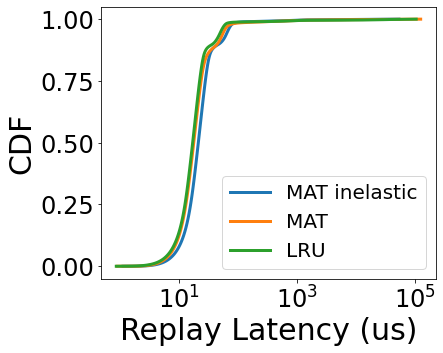

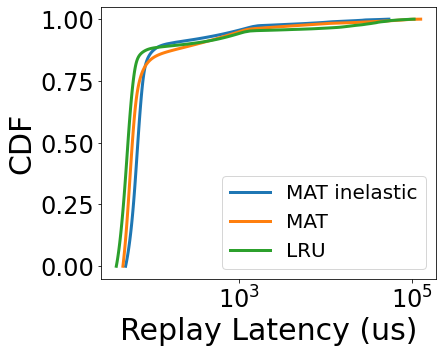

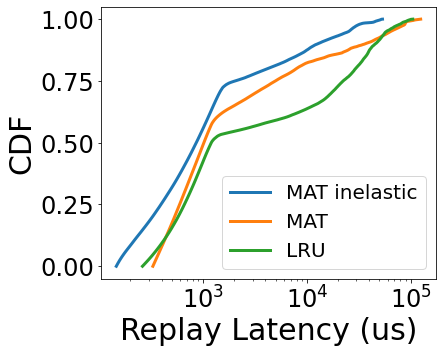

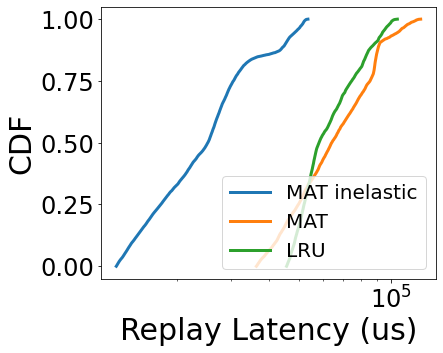

In [148]:
import matplotlib.pyplot as plt

for n_tail in (0, 19900000, 1990000, 199000):
    plt.figure(figsize=(6,5))
    x = t_ine_sort[-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='MAT inelastic')
    x = t_mat_sort[-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='MAT')
    x = t_lru_sort[-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='LRU')

    #plt.ylim(top=0.99999)
    #plt.ylim(bottom=0.1)
    plt.xscale('log')
    plt.xlabel('Replay Latency (us)', fontsize=30)
    plt.ylabel('CDF', fontsize=30)
    plt.legend(ncol=1, prop={'size': 20}, loc='lower right')

    plt.show()

In [8]:
e_mat_sort = np.sort(e_mat)
e_ine_sort = np.sort(e_ine)
e_lru_sort = np.sort(e_lru)
print('done')

done


In [147]:
for n_tail in [19900000, 1990000, 199000]:
    plt.figure(figsize=(6,5))
    x = e_ine_sort[-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='MAT inelastic')
    x = e_mat_sort[-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='MAT')
    x = e_lru_sort[-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='LRU')

    plt.xscale('log')
    plt.xlabel('Cache Latency (us)', fontsize=28)
    plt.ylabel('CDF', fontsize=28)
    plt.legend(ncol=1, prop={'size': 20}, loc='lower right')

    plt.show()

NameError: name 'e_ine_sort' is not defined

<Figure size 432x360 with 0 Axes>

In [76]:
d = 512
import numpy as np
def read_tt(f):
    miss_list = []
    with open(f, 'r') as fin:
        lines = fin.readlines()
        for line in lines:
            if line.startswith('target throughput:'):
                miss_list.append(line.split()[-1])
    return np.array(miss_list, dtype=np.float32)
ec_tt = read_tt(f'/nfs/16_{d}/eEC/1.log')[:1990]
print(len(ec_tt))
eci_tt = read_tt(f'/nfs/16_{d}/EC/1.log')[:1990]
print(len(eci_tt))
lru_tt = read_tt(f'/nfs/16_{d}/LRU/1.log')[:1990]
print(len(lru_tt))

1990
1990
1990


In [84]:
import numpy as np
def read_miss(f):
    miss_list = []
    tt = []
    with open(f, 'r') as fin:
        lines = fin.readlines()
        for line in lines:
            if line.startswith('miss ratio:'):
                miss_list.append(line.split()[-1])
    return np.array(miss_list, dtype=np.float32)
ec_miss_ = read_miss(f'/nfs/16_{d}/eEC/0.log')[:1990]
print(len(ec_miss_))
eci_miss_ = read_miss(f'/nfs/16_{d}/EC/0.log')[:1990]
print(len(eci_miss_))
lru_miss_ = read_miss(f'/nfs/16_{d}/LRU/0.log')[:1990]
print(len(lru_miss_))

1990
1990
1990


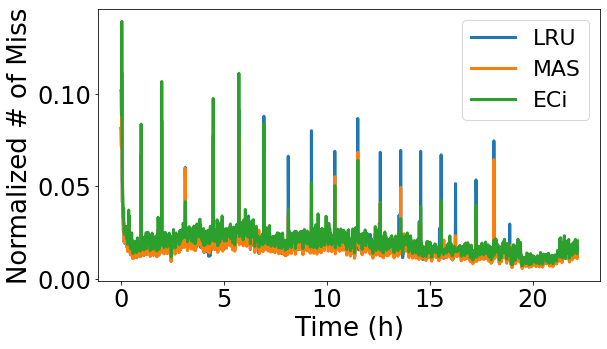

In [139]:
plt.figure(figsize=(9,5))
lru_miss = lru_miss_ * lru_tt / max(lru_miss_ * lru_tt)
ec_miss = ec_miss_ * lru_tt / max(lru_miss_ * lru_tt)
eci_miss = eci_miss_ * lru_tt / max(lru_miss_ * lru_tt)
n = 100000
a1 = np.average(m_lru.reshape(-1, n), axis=1)
a2 = np.average(m_ine.reshape(-1, n), axis=1)

begin_t = 1533121514
end_t = 1533201411
scale = (end_t - begin_t) / 3600/ len(a1) 
plt.plot(np.array(range(len(a1))) * scale, a1, label='LRU')

a_ec = np.average(m_mat.reshape(-1, n), axis=1)
plt.plot(np.array(range(len(a_ec))) * scale, a_ec, label='MAS')
plt.plot(np.array(range(len(a1))) * scale, a2, label='ECi')


plt.xlabel('Time (h)', fontsize=26)
plt.ylabel('Normalized # of Miss', fontsize=26)
plt.legend(ncol=1, prop={'size': 22}, loc='upper right')

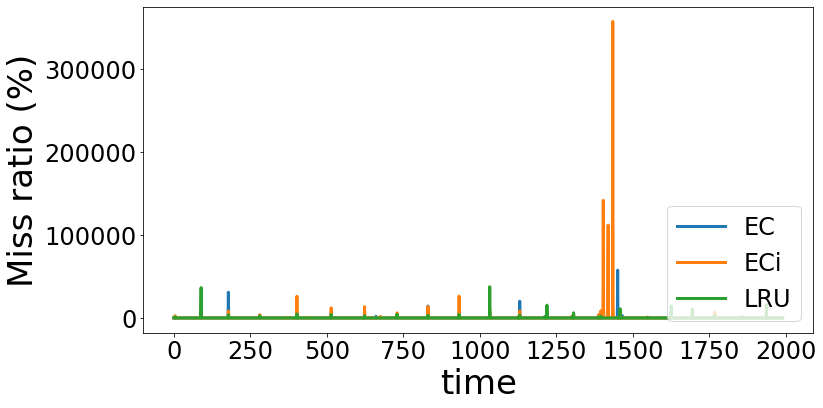

In [28]:
plt.figure(figsize=(12,6))
n = 100000
a1 = np.average(t1.reshape(-1, n), axis=1)
a2 = np.average(t2.reshape(-1, n), axis=1)
a3 = np.average(t3.reshape(-1, n), axis=1)


plt.plot(range(len(a2)), a2, label='EC')
plt.plot(range(len(a1)), a1, label='ECi')
plt.plot(range(len(a3)), a3, label='LRU')

#a_ec = np.average(ec_miss.reshape(-1, n), axis=1)
#plt.plot(range(len(a_ec)), a_ec, label='EC')


plt.xlabel('time', fontsize=34)
plt.ylabel('Miss ratio (%)', fontsize=34)
#plt.yscale('log')
plt.legend(ncol=1, prop={'size': 24}, loc='lower right')

In [34]:
import numpy as np
def read_tt(f):
    miss_list = []
    with open(f, 'r') as fin:
        lines = fin.readlines()
        for line in lines:
            if line.startswith('target throughput:'):
                miss_list.append(line.split()[-1])
    return np.array(miss_list, dtype=np.float32)
ec_tt = read_tt('/nfs/runner/eEC/0.log')
print(len(ec_tt))
eci_tt = read_tt('/nfs/runner/EC/0.log')[:1990]
print(len(eci_tt))
lru_tt = read_tt('/nfs/runner/LRU/0.log')
print(len(lru_tt))

1990
1990
1990


In [49]:
plt.figure(figsize=(9,6))
n = 10
#a_lru = np.average(lru_tt.reshape(-1, n), axis=1)
#a_eci = np.average(eci_tt.reshape(-1, n), axis=1)
a_ec = np.average(ec_tt.reshape(-1, n), axis=1)
a_lru = lru_tt
a_eci = eci_tt
#a_ec = ec_tt

begin_t = 1533121514
end_t = 1533201411
scale = (end_t - begin_t) / 3600/ len(a_ec) 
plt.plot(np.array(range(len(a_ec))) * scale , a_ec, label='EC')

plt.xlabel('time (hour)', fontsize=34)
plt.ylabel('Request Rate (%)', fontsize=34)
#plt.legend(ncol=1, prop={'size': 24}, loc='lower right')

indices = np.argsort(a_ec)[-20:]
print(indices, a_ec[indices])

NameError: name 'ec_tt' is not defined

<Figure size 648x432 with 0 Axes>

In [59]:
e2e_latencys = [t1, t2, t3]
e2e_peak = [[], [], []]
for i in range(3):
    peak_index = []
    for j in range(len(indices)):
        #print(int(second_to_seq[indices[j]-1]), int(second_to_seq[indices[j]]))
        #peak_index.extend(range(int(second_to_seq[indices[j]-1]), int(second_to_seq[indices[j]])))
        #    print(indices[j] * 100000 - 300000, indices[j] * 100000 + 200000)
        e2e_peak[i].extend(e2e_latencys[i][int(second_to_seq[indices[j]-1]): int(second_to_seq[indices[j]])])
        #print(peak_index)
    #e2e_peak[i] = e2e_latencys[i][peak_index]
    e2e_peak[i] = np.array(e2e_peak[i])
    e2e_peak[i] = np.sort(e2e_peak[i])
print('done')
print(len(e2e_peak[0]))

done
830482


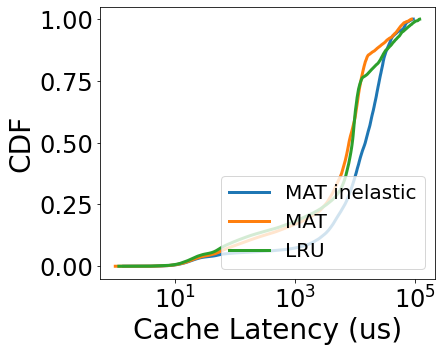

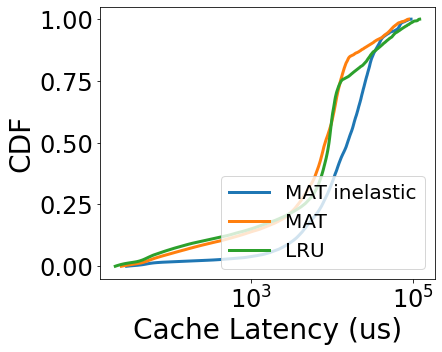

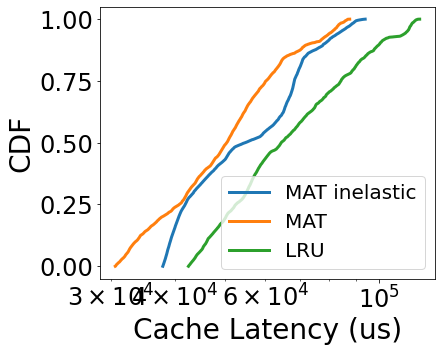

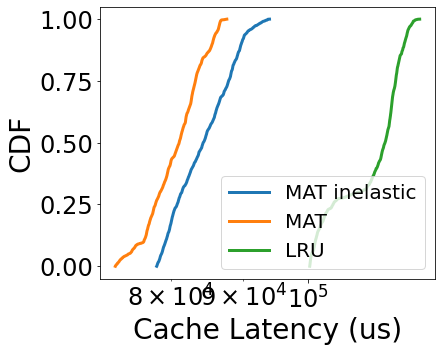

In [60]:
for n_tail in [0, 800000, 80000, 8000]:
    plt.figure(figsize=(6,5))
    x = e2e_peak[0][-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='MAT inelastic')
    x = e2e_peak[1][-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='MAT')
    x = e2e_peak[2][-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='LRU')

    plt.xscale('log')
    plt.xlabel('Cache Latency (us)', fontsize=28)
    plt.ylabel('CDF', fontsize=28)
    plt.legend(ncol=1, prop={'size': 20}, loc='lower right')

    #plt.ylim(top=0.99999)
    #plt.ylim(bottom=bottom)
    plt.show()

In [87]:
t_latencys = [t1, t2, t3]
t_peak = [[], [], []]
for i in range(3):
    #for j in range(len(indices)):
    #    print(indices[j] * 100000 - 300000, indices[j] * 100000 + 200000)
    #    e2e_peak[i].extend(e2e_latencys[i][indices[j] * 100000 - 100000: indices[j] * 100000 + 0])
    t_peak[i].extend(t_latencys[i][37 * 1000000 - 4000000: 37 * 1000000 + 4000000])
    t_peak[i] = np.array(t_peak[i])
    t_peak[i] = np.sort(t_peak[i])
print('done')
print(len(t_peak[0]))

done
8000000


In [87]:
t_latencys = [t1, t2, t3]
t_peak = [[], [], []]
for i in range(3):
    #for j in range(len(indices)):
    #    print(indices[j] * 100000 - 300000, indices[j] * 100000 + 200000)
    #    e2e_peak[i].extend(e2e_latencys[i][indices[j] * 100000 - 100000: indices[j] * 100000 + 0])
    t_peak[i].extend(t_latencys[i][37 * 1000000 - 4000000: 37 * 1000000 + 4000000])
    t_peak[i] = np.array(t_peak[i])
    t_peak[i] = np.sort(t_peak[i])
print('done')
print(len(t_peak[0]))

done
8000000


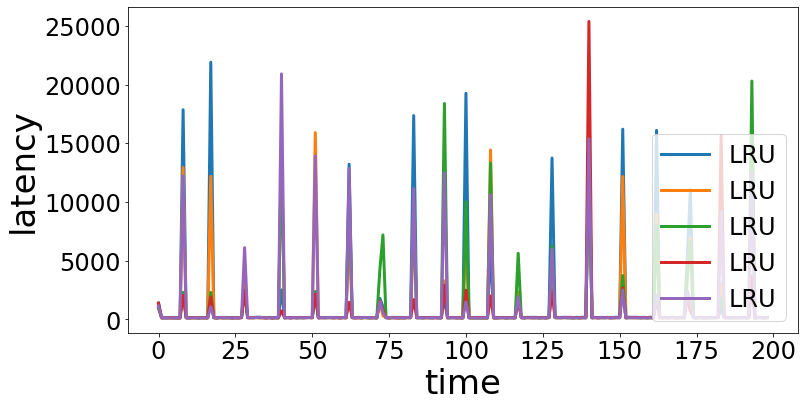

In [12]:
# plot latency vs. time

plt.figure(figsize=(12,6))
n = 1000000

for i in range(len(t_lru)):
    lat = np.average(t_lru[i].reshape(-1, n), axis=1)
    plt.plot(range(len(lat)), lat, label='LRU')


plt.xlabel('time', fontsize=34)
plt.ylabel('latency', fontsize=34)
#plt.yscale('log')
plt.legend(ncol=1, prop={'size': 24}, loc='lower right')

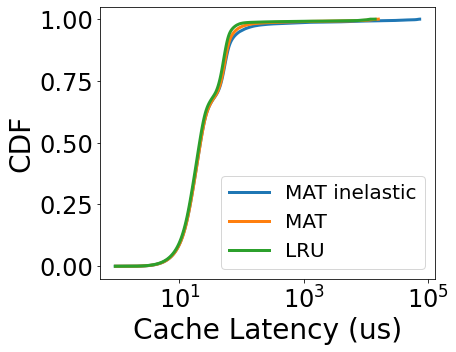

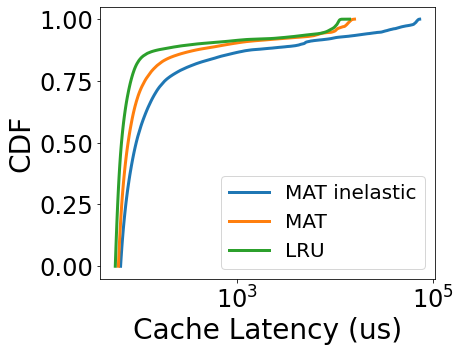

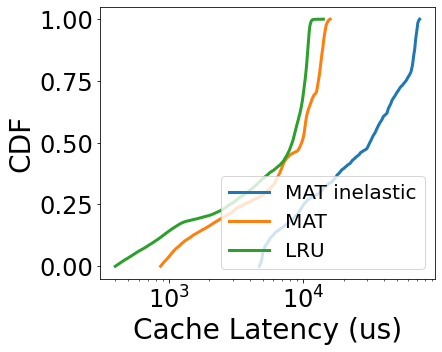

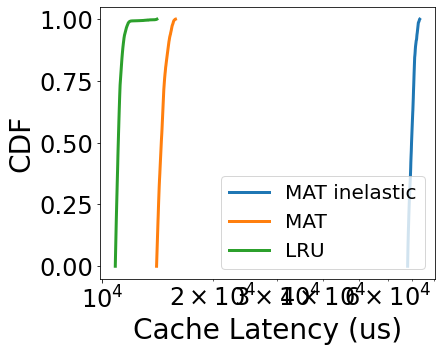

In [88]:
for n_tail in [0, 800000, 80000, 8000]:
    plt.figure(figsize=(6,5))
    x = t_peak[0][-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='MAT inelastic')
    x = t_peak[1][-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='MAT')
    x = t_peak[2][-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='LRU')

    plt.xscale('log')
    plt.xlabel('Cache Latency (us)', fontsize=28)
    plt.ylabel('CDF', fontsize=28)
    plt.legend(ncol=1, prop={'size': 20}, loc='lower right')

    #plt.ylim(top=0.99999)
    #plt.ylim(bottom=bottom)
    plt.show()

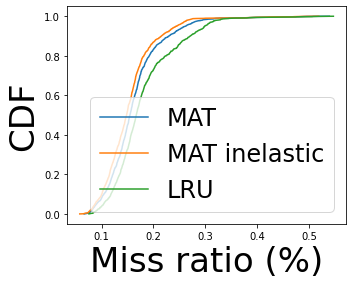

In [23]:
ec_miss_sort = np.sort(ec_miss[500:1900])
eci_miss_sort = np.sort(eci_miss[500:1900])
lru_miss_sort = np.sort(lru_miss[500:1900])
plt.figure(figsize=(5,4))
x = ec_miss_sort
y = np.arange(len(x))/float(len(x))
plt.plot(x, y, label='MAT')
x = eci_miss_sort
y = np.arange(len(x))/float(len(x))
plt.plot(x, y, label='MAT inelastic')
x = lru_miss_sort
y = np.arange(len(x))/float(len(x))
plt.plot(x, y, label='LRU')

plt.xlabel('Miss ratio (%)', fontsize=34)
plt.ylabel('CDF', fontsize=34)
plt.legend(ncol=1, prop={'size': 24}, loc='lower right')

plt.show()

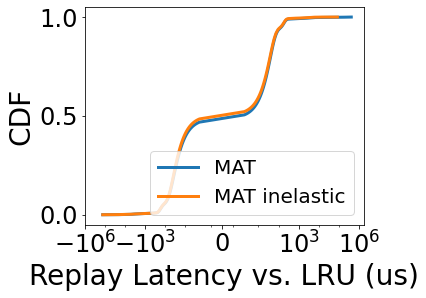

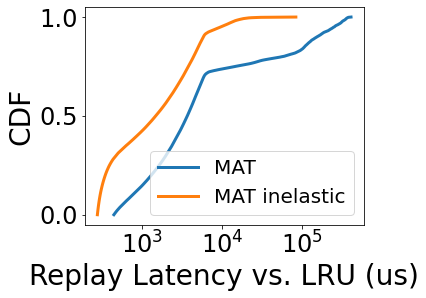

In [97]:
import matplotlib.pyplot as plt

for n_tail in (0, 1000000):
    plt.figure(figsize=(5,4))
    diff_t = t_mat-t_lru
    x = np.sort(diff_t)[-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='MAT')
    plt.xscale('symlog')

    diff_t = t_ine-t_lru
    x = np.sort(diff_t)[-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='MAT inelastic')
    plt.xscale('symlog')
    if n_tail == 0:
        plt.xticks([-1000000, -1000, 0, 1000, 1000000], rotation=0)
    plt.xlabel('Replay Latency vs. LRU (us)', fontsize=28)
    plt.ylabel('CDF', fontsize=28)
    plt.legend(ncol=1, prop={'size': 20}, loc='lower right')

    plt.show()

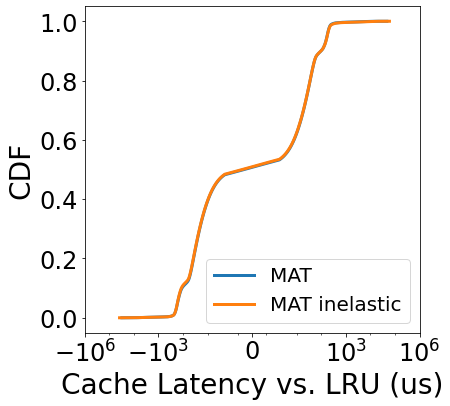

In [90]:
for n_tail in (0, 1000000):
    plt.figure(figsize=(5,4))
    diff_t = e_mat-e_lru
    x = np.sort(diff_t)[-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='MAT')
    plt.xscale('symlog')

    diff_t = e_ine-e_lru
    x = np.sort(diff_t)[-n_tail:]
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label='MAT inelastic')
    plt.xscale('symlog')
    if n_tail == 0:
        plt.xticks([-1000000, -1000, 0, 1000, 1000000], rotation=0)
    plt.xlabel('Cache Latency vs. LRU (us)', fontsize=28)
    plt.ylabel('CDF', fontsize=28)
    plt.legend(ncol=1, prop={'size': 20}, loc='lower right')

    plt.show()